In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Loading and Exploring Data

In [2]:
data = pd.read_csv(r'Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv')

In [3]:
data_info = data.info()
data_preview = data.head()
data_info, data_preview


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621000 entries, 0 to 620999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Data As Of          621000 non-null  object 
 1   Start Date          621000 non-null  object 
 2   End Date            621000 non-null  object 
 3   Group               621000 non-null  object 
 4   Year                608580 non-null  float64
 5   Month               558900 non-null  float64
 6   State               621000 non-null  object 
 7   Condition Group     621000 non-null  object 
 8   Condition           621000 non-null  object 
 9   ICD10_codes         621000 non-null  object 
 10  Age Group           621000 non-null  object 
 11  COVID-19 Deaths     437551 non-null  float64
 12  Number of Mentions  443423 non-null  float64
 13  Flag                183449 non-null  object 
dtypes: float64(4), object(10)
memory usage: 66.3+ MB


(None,
    Data As Of  Start Date    End Date     Group  Year  Month          State  \
 0  09/24/2023  01/01/2020  09/23/2023  By Total   NaN    NaN  United States   
 1  09/24/2023  01/01/2020  09/23/2023  By Total   NaN    NaN  United States   
 2  09/24/2023  01/01/2020  09/23/2023  By Total   NaN    NaN  United States   
 3  09/24/2023  01/01/2020  09/23/2023  By Total   NaN    NaN  United States   
 4  09/24/2023  01/01/2020  09/23/2023  By Total   NaN    NaN  United States   
 
         Condition Group                Condition ICD10_codes Age Group  \
 0  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
 1  Respiratory diseases  Influenza and pneumonia     J09-J18     25-34   
 2  Respiratory diseases  Influenza and pneumonia     J09-J18     35-44   
 3  Respiratory diseases  Influenza and pneumonia     J09-J18     45-54   
 4  Respiratory diseases  Influenza and pneumonia     J09-J18     55-64   
 
    COVID-19 Deaths  Number of Mentions Flag  
 0          

In [4]:

data['Data As Of'] = pd.to_datetime(data['Data As Of'], errors='coerce')
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')

numeric_summary = data.describe()

missing_values = data.isnull().sum()

categorical_columns = ['Group', 'State', 'Condition Group', 'Condition', 'Age Group']
unique_values = {col: data[col].nunique() for col in categorical_columns}

numeric_summary, missing_values, unique_values


(                Data As Of                     Start Date  \
 count               621000                         621000   
 mean   2023-09-24 00:00:00  2021-10-08 05:45:36.000000768   
 min    2023-09-24 00:00:00            2020-01-01 00:00:00   
 25%    2023-09-24 00:00:00            2020-11-01 00:00:00   
 50%    2023-09-24 00:00:00            2021-10-16 12:00:00   
 75%    2023-09-24 00:00:00            2022-10-01 00:00:00   
 max    2023-09-24 00:00:00            2023-09-01 00:00:00   
 std                    NaN                            NaN   
 
                             End Date           Year          Month  \
 count                         621000  608580.000000  558900.000000   
 mean   2021-12-27 23:02:23.999999488    2021.408163       6.200000   
 min              2020-01-31 00:00:00    2020.000000       1.000000   
 25%              2020-12-31 00:00:00    2020.000000       3.000000   
 50%              2021-12-31 00:00:00    2021.000000       6.000000   
 75%          

## Step 1: Data Cleaning

In [5]:

data['Data As Of'] = pd.to_datetime(data['Data As Of'], errors='coerce')
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')

data = data.drop(columns=['Flag'])

data['Year'] = data['Year'].fillna(data['Start Date'].dt.year)
data['Month'] = data['Month'].fillna(data['Start Date'].dt.month)

data = data.dropna(subset=['COVID-19 Deaths'])


data['COVID-19 Deaths'] = data['COVID-19 Deaths'].astype(int)
data['Number of Mentions'] = data['Number of Mentions'].fillna(0).astype(int)


data_cleaned_info = data.info()
data_cleaned_preview = data.head()

data_cleaned_info, data_cleaned_preview


<class 'pandas.core.frame.DataFrame'>
Index: 437551 entries, 0 to 620999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Data As Of          437551 non-null  datetime64[ns]
 1   Start Date          437551 non-null  datetime64[ns]
 2   End Date            437551 non-null  datetime64[ns]
 3   Group               437551 non-null  object        
 4   Year                437551 non-null  float64       
 5   Month               437551 non-null  float64       
 6   State               437551 non-null  object        
 7   Condition Group     437551 non-null  object        
 8   Condition           437551 non-null  object        
 9   ICD10_codes         437551 non-null  object        
 10  Age Group           437551 non-null  object        
 11  COVID-19 Deaths     437551 non-null  int32         
 12  Number of Mentions  437551 non-null  int32         
dtypes: datetime64[ns](3), float64(2), 

(None,
   Data As Of Start Date   End Date     Group    Year  Month          State  \
 0 2023-09-24 2020-01-01 2023-09-23  By Total  2020.0    1.0  United States   
 1 2023-09-24 2020-01-01 2023-09-23  By Total  2020.0    1.0  United States   
 2 2023-09-24 2020-01-01 2023-09-23  By Total  2020.0    1.0  United States   
 3 2023-09-24 2020-01-01 2023-09-23  By Total  2020.0    1.0  United States   
 4 2023-09-24 2020-01-01 2023-09-23  By Total  2020.0    1.0  United States   
 
         Condition Group                Condition ICD10_codes Age Group  \
 0  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
 1  Respiratory diseases  Influenza and pneumonia     J09-J18     25-34   
 2  Respiratory diseases  Influenza and pneumonia     J09-J18     35-44   
 3  Respiratory diseases  Influenza and pneumonia     J09-J18     45-54   
 4  Respiratory diseases  Influenza and pneumonia     J09-J18     55-64   
 
    COVID-19 Deaths  Number of Mentions  
 0             1569    

## Step 2: Visualizations

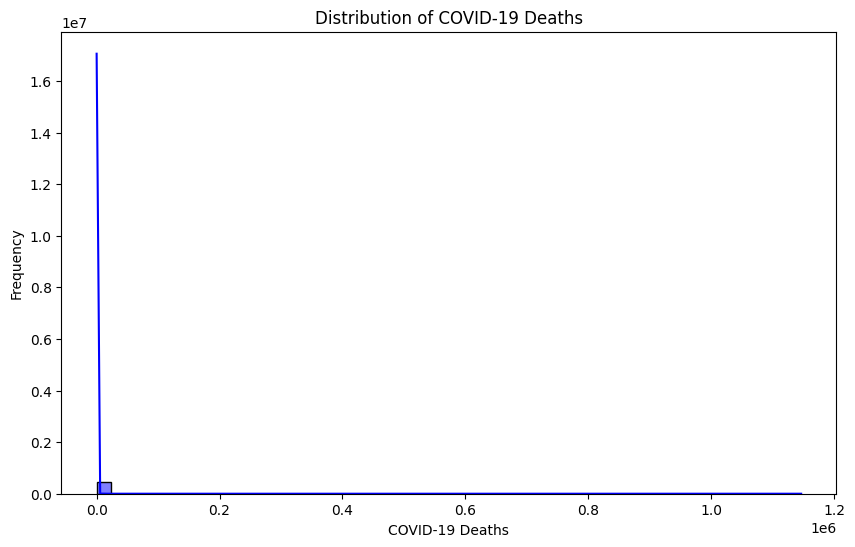

C:\Users\ashtik\AppData\Local\Temp\ipykernel_7484\2914317415.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age Group', y='COVID-19 Deaths', data=data, palette='viridis')


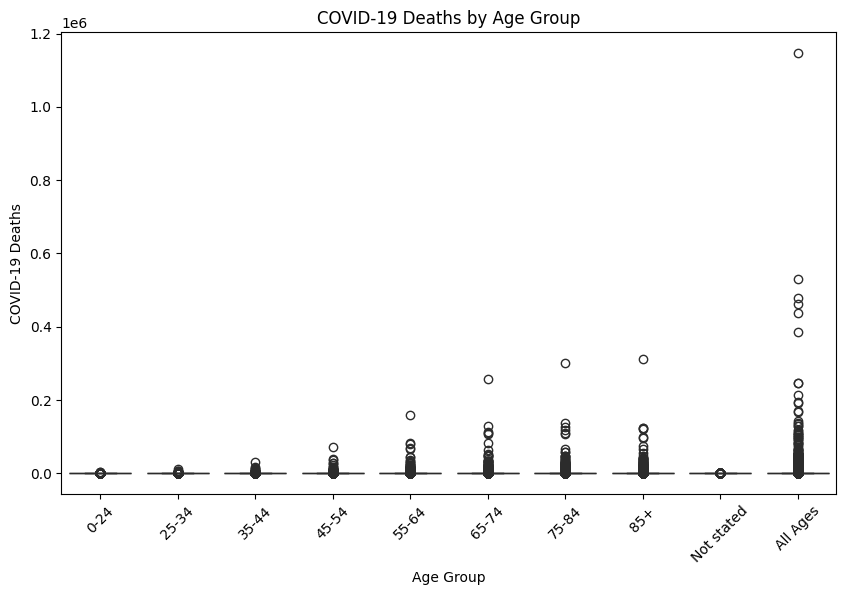

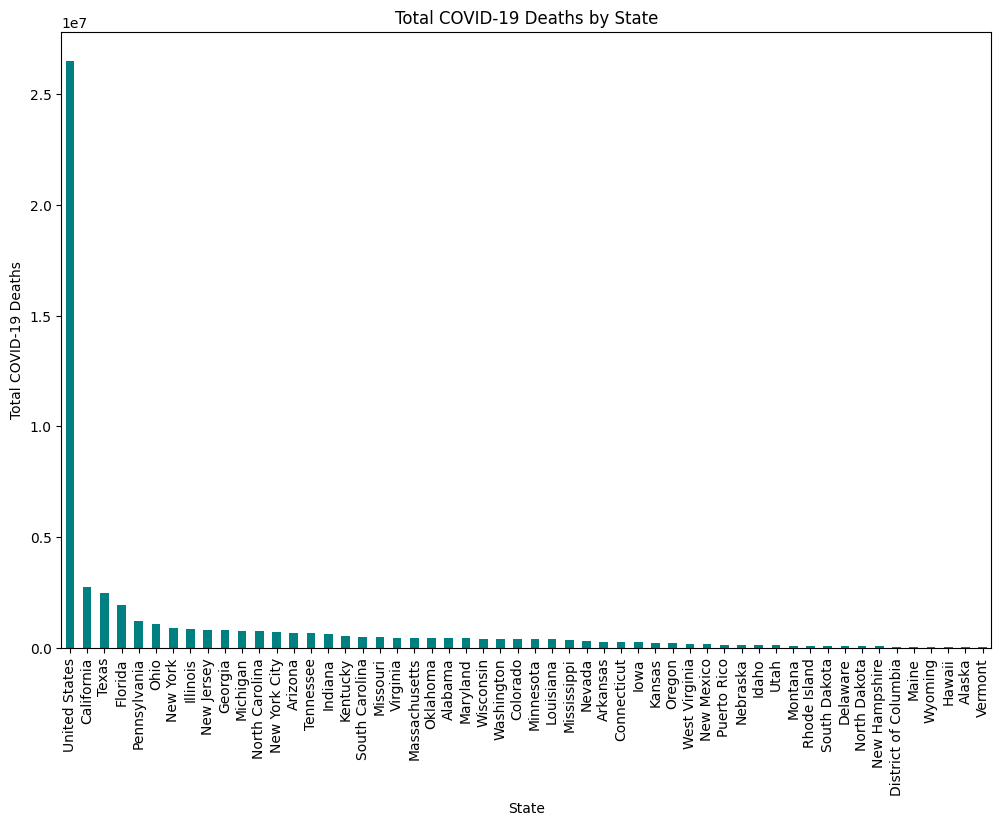

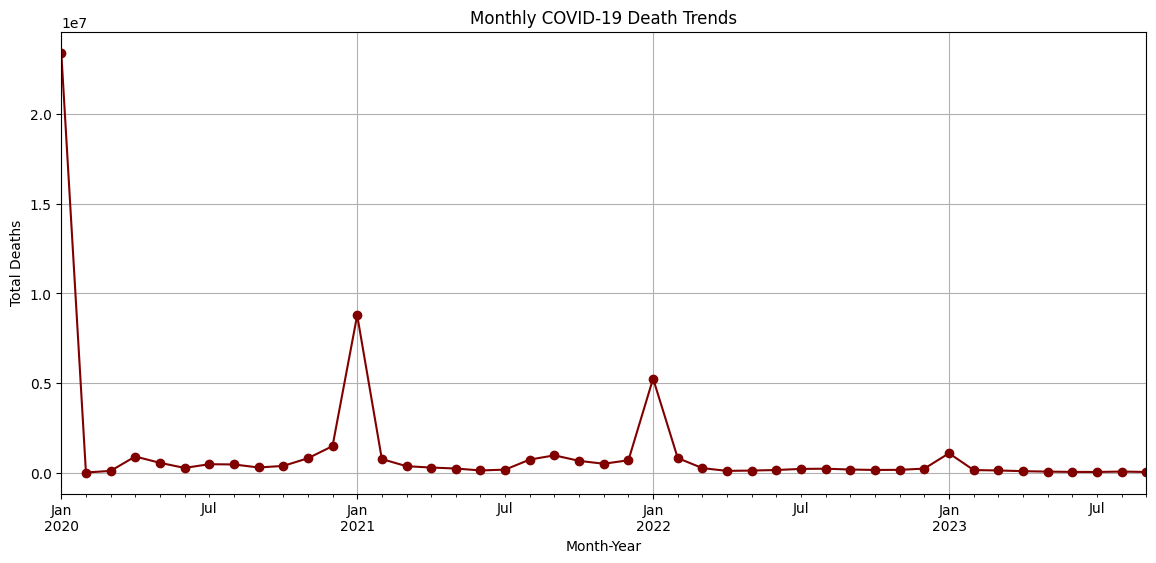

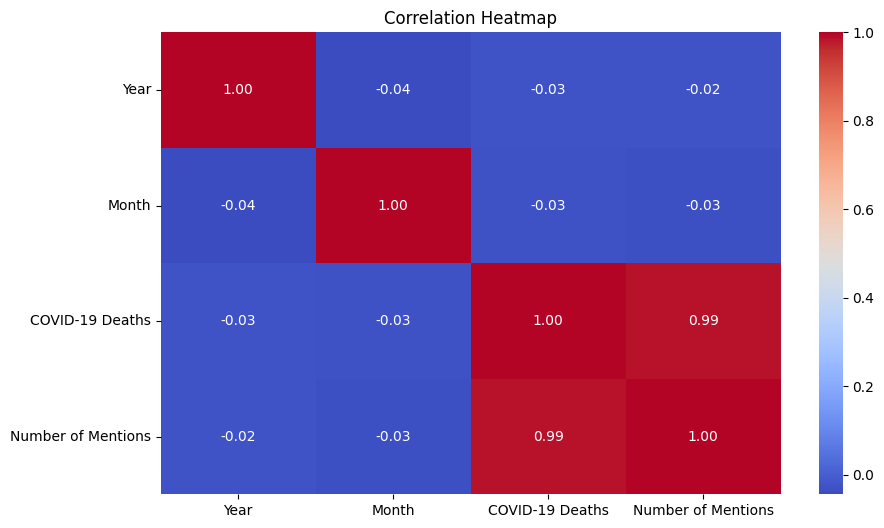

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data['COVID-19 Deaths'], bins=50, kde=True, color='blue')
plt.title('Distribution of COVID-19 Deaths')
plt.xlabel('COVID-19 Deaths')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y='COVID-19 Deaths', data=data, palette='viridis')
plt.title('COVID-19 Deaths by Age Group')
plt.xlabel('Age Group')
plt.ylabel('COVID-19 Deaths')
plt.xticks(rotation=45)
plt.show()


state_deaths = data.groupby('State')['COVID-19 Deaths'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
state_deaths.plot(kind='bar', color='teal')
plt.title('Total COVID-19 Deaths by State')
plt.xlabel('State')
plt.ylabel('Total COVID-19 Deaths')
plt.show()


data['Month-Year'] = data['Start Date'].dt.to_period('M')
monthly_deaths = data.groupby('Month-Year')['COVID-19 Deaths'].sum()
plt.figure(figsize=(14, 6))
monthly_deaths.plot(kind='line', marker='o', color='maroon')
plt.title('Monthly COVID-19 Death Trends')
plt.xlabel('Month-Year')
plt.ylabel('Total Deaths')
plt.grid()
plt.show()

numeric_columns = ['Year', 'Month', 'COVID-19 Deaths', 'Number of Mentions']
plt.figure(figsize=(10, 6))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [7]:
data

,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Month-Year
0,2023-09-24,2020-01-01,2023-09-23,By Total,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,1569,1647,2020-01
1,2023-09-24,2020-01-01,2023-09-23,By Total,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,5804,6029,2020-01
2,2023-09-24,2020-01-01,2023-09-23,By Total,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,15080,15699,2020-01
3,2023-09-24,2020-01-01,2023-09-23,By Total,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,37414,38878,2020-01
4,2023-09-24,2020-01-01,2023-09-23,By Total,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,82668,85708,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620995,2023-09-24,2023-05-01,2023-05-31,By Month,2023.0,5.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,67,67,2023-05
620996,2023-09-24,2023-06-01,2023-06-30,By Month,2023.0,6.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,122,122,2023-06
620997,2023-09-24,2023-07-01,2023-07-31,By Month,2023.0,7.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,114,114,2023-07
620998,2023-09-24,2023-08-01,2023-08-31,By Month,2023.0,8.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,78,78,2023-08


## Create training, validation and test datasets

In [8]:

data['Data As Of'] = pd.to_datetime(data['Data As Of'], errors='coerce')
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')

data['Year'] = data['Year'].fillna(data['Start Date'].dt.year)
data['Month'] = data['Month'].fillna(data['Start Date'].dt.month)

data = data.dropna(subset=['COVID-19 Deaths'])

data['COVID-19 Deaths'] = data['COVID-19 Deaths'].astype(int)
data['Number of Mentions'] = data['Number of Mentions'].fillna(0).astype(int)

Q1 = np.percentile(data['COVID-19 Deaths'], 25) 
Q3 = np.percentile(data['COVID-19 Deaths'], 75)
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['COVID-19 Deaths'] >= lower_bound) & (data['COVID-19 Deaths'] <= upper_bound)]

scaler = MinMaxScaler()
data['COVID-19 Deaths Scaled'] = scaler.fit_transform(data[['COVID-19 Deaths']])

label_encoders = {}
categorical_columns = ['Group', 'State', 'Condition Group', 'Condition', 'Age Group']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


features = ['Group', 'State', 'Condition Group', 'Condition', 'Age Group', 'Year', 'Month', 'Number of Mentions']
target = 'COVID-19 Deaths Scaled'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((298410, 8), (74603, 8))

In [9]:
X_train

,Group,State,Condition Group,Condition,Age Group,Year,Month,Number of Mentions
151280,0,7,6,14,1,2022.0,12.0,0
92192,0,1,5,12,9,2022.0,9.0,0
163965,0,8,8,18,3,2022.0,7.0,0
559877,0,49,9,0,1,2022.0,9.0,0
136858,0,6,9,17,1,2021.0,2.0,0
...,...,...,...,...,...,...,...,...
440928,0,35,10,21,9,2021.0,7.0,0
609620,0,53,5,12,7,2020.0,6.0,0
236688,0,15,8,18,8,2022.0,10.0,12
260937,0,18,9,19,9,2022.0,4.0,0


## ML Models

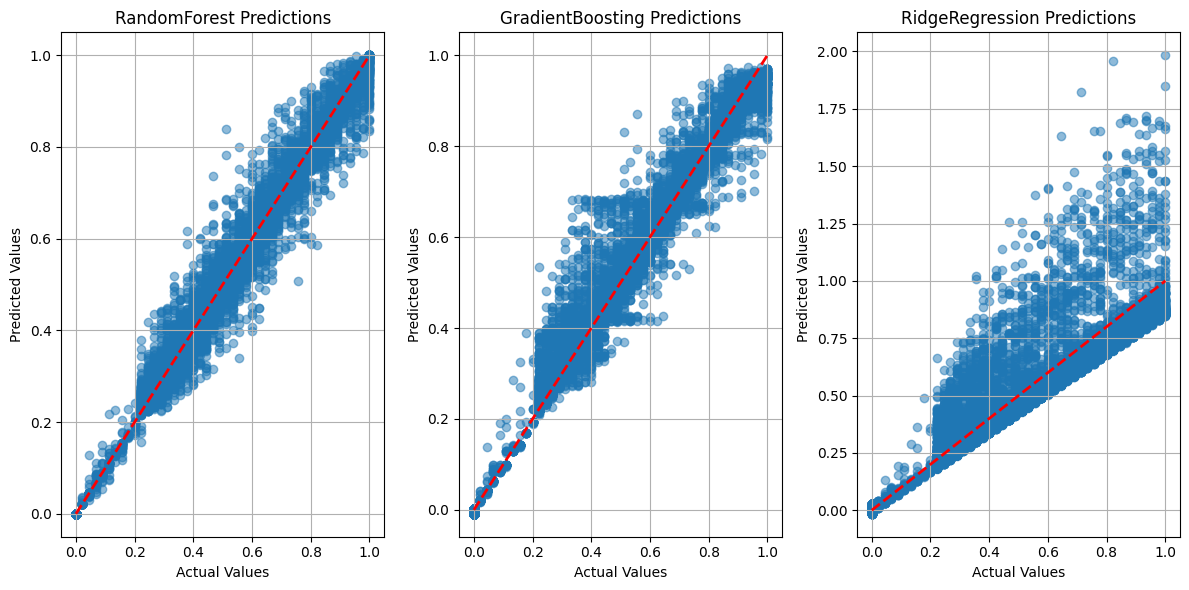

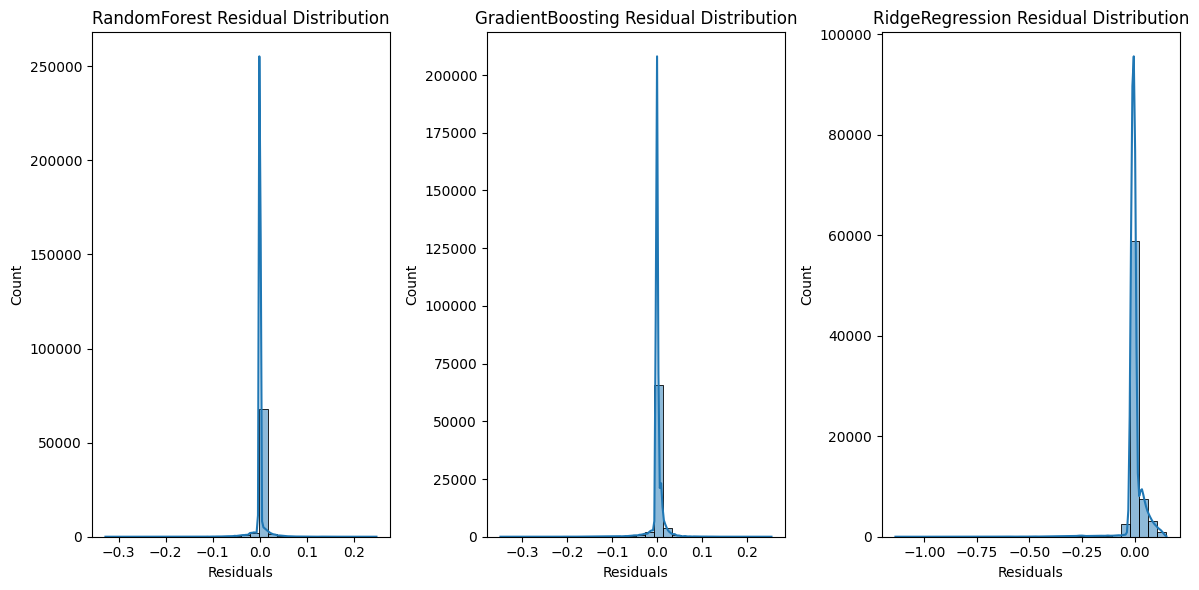

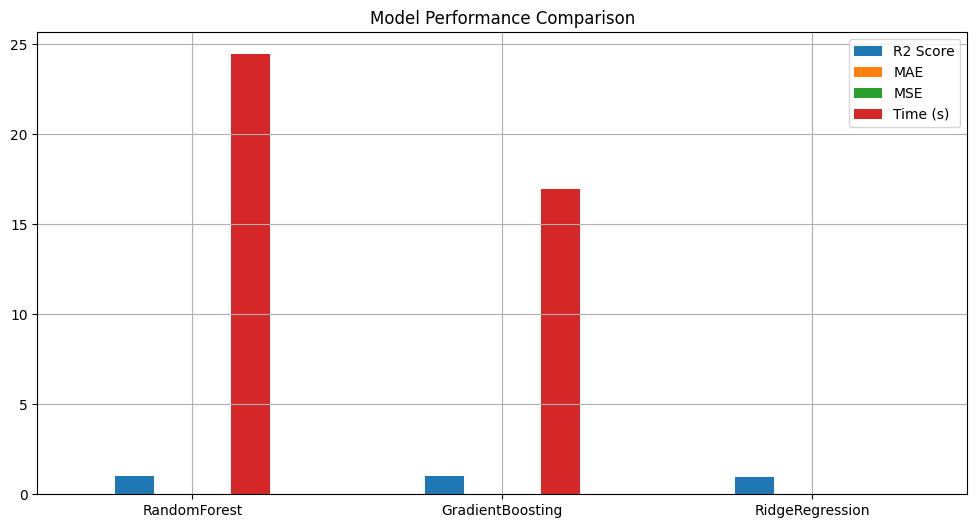

{'RandomForest': {'R2 Score': 0.9960049746071361,
  'MAE': 0.0035796951865206977,
  'MSE': 0.00019528566537307048,
  'MAPE (%)': 0.8219900379031426,
  'Time (s)': 24.438978910446167},
 'GradientBoosting': {'R2 Score': 0.9933384962808873,
  'MAE': 0.006024953864177243,
  'MSE': 0.0003256290156492671,
  'MAPE (%)': 1042663157.2976714,
  'Time (s)': 16.945069551467896},
 'RidgeRegression': {'R2 Score': 0.9466698502475369,
  'MAE': 0.02136525849361194,
  'MSE': 0.0026068955149717715,
  'MAPE (%)': 6167577886.695592,
  'Time (s)': 0.0318603515625}}

In [12]:

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "RidgeRegression": Ridge(alpha=1.0)
}

epsilon = 1e-10 
results = {}

plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(models.items()):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    runtime = end_time - start_time
    
    results[name] = {"R2 Score": r2, "MAE": mae, "MSE": mse, "MAPE (%)": mape, "Time (s)": runtime}
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Predictions")
    plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i, (name, model) in enumerate(models.items()):
    residuals = y_test - model.predict(X_test)
    
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"{name} Residual Distribution")

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(results).T
metrics_df[['R2 Score', 'MAE', 'MSE', 'Time (s)']].plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.grid()
plt.show()

results


## Neural Network

In [14]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle = True)


scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

class COVIDDeathPredictor(nn.Module):
    def __init__(self, input_dim):
        super(COVIDDeathPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = COVIDDeathPredictor(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

epochs = 10
best_loss = float('inf')
patience = 10
trigger = 0

print("Training Started...\n")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor).item()

    end_time = time.time()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.6f}, Validation Loss: {val_loss:.6f}, Time: {end_time - start_time:.2f}s")

    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        trigger = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger += 1
        if trigger >= patience:
            print("\nEarly stopping at epoch", epoch+1)
            break

print("\nTraining Complete!\n")


model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).numpy().flatten()

test_predictions = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()

r2_nn = r2_score(y_test_original, test_predictions)
mse_nn = mean_squared_error(y_test_original, test_predictions)

print(f'Neural Network R² Score: {r2_nn}')
print(f'Neural Network MSE: {mse_nn}')


Training Started...

Epoch 1/10, Training Loss: 0.041451, Validation Loss: 0.016582, Time: 6.59s
Epoch 2/10, Training Loss: 0.018616, Validation Loss: 0.010855, Time: 6.54s
Epoch 3/10, Training Loss: 0.011956, Validation Loss: 0.006049, Time: 6.42s
Epoch 4/10, Training Loss: 0.008483, Validation Loss: 0.006171, Time: 6.49s
Epoch 5/10, Training Loss: 0.007454, Validation Loss: 0.006210, Time: 6.51s
Epoch 6/10, Training Loss: 0.006769, Validation Loss: 0.006507, Time: 6.39s
Epoch 7/10, Training Loss: 0.006501, Validation Loss: 0.005982, Time: 6.47s
Epoch 8/10, Training Loss: 0.006242, Validation Loss: 0.005940, Time: 6.47s
Epoch 9/10, Training Loss: 0.005993, Validation Loss: 0.005881, Time: 6.36s
Epoch 10/10, Training Loss: 0.005989, Validation Loss: 0.006629, Time: 6.57s

Training Complete!

Neural Network R² Score: 0.9941139221191406
Neural Network MSE: 0.00028772561927326024


C:\Users\ashtik\AppData\Local\Temp\ipykernel_7484\2477607595.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


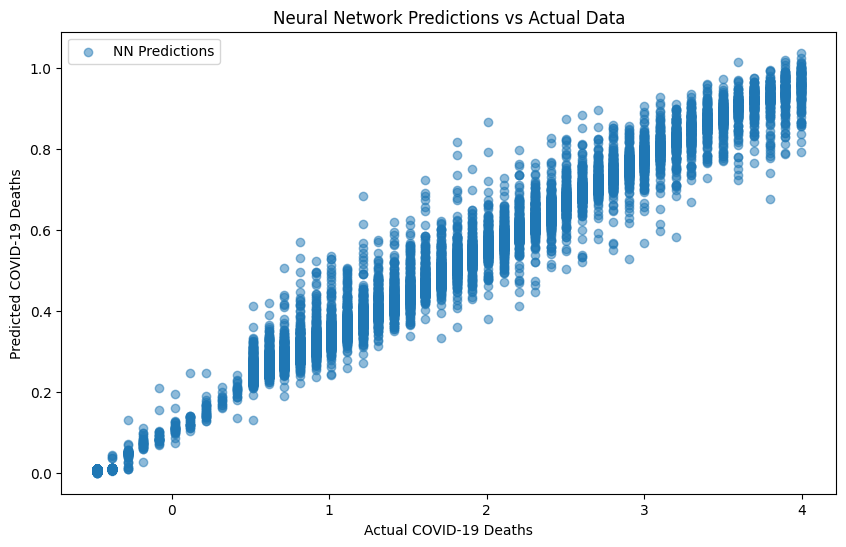

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, test_predictions, alpha=0.5, label='NN Predictions')
plt.xlabel("Actual COVID-19 Deaths")
plt.ylabel("Predicted COVID-19 Deaths")
plt.title("Neural Network Predictions vs Actual Data")
plt.legend()
plt.show()